# Sample Philips 3D RF Analysis

In [5]:
%load_ext autoreload
%autoreload 2
import os
from pathlib import Path

print(Path().cwd())
os.chdir(Path().cwd().parent)
print(Path().cwd())

/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS/CLI-Demos
/Users/davidspector/Home/Stanford/QuantUS Projects/PyQuantUS


# Select Image & Phantom and Parse

In [6]:
from pyquantus.parse.philips3dRf import philipsRfParser3d, getVolume

In [7]:
rfPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Philips 3D RF/SHC-P004-V03-RF1_20241015_155205.rf')
phantomPath = Path('/Volumes/TOSHIBA EXT/Philips 3D RF/Phantom/IMAN-PHANTOM-RF2_20250311_162604.rf')

In [8]:
imgData, imgInfo, phantomData, phantomInfo = philipsRfParser3d(rfPath, phantomPath)

Reading SIP scan conversion VDB Params...
Finished reading SIP scan converstion VDB params...
Opening: /Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Philips 3D RF/SHC-P004-V03-RF1_20241015_155205.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 6
	Header Size: 880 bytes

Elapsed time is 0:01:31.336228 seconds.
Parsing header info ...
Elapsed time is 0:01:31.568530 seconds.
Parsing RF data ...
Elapsed time is 0:01:47.628982 seconds.
Organizing based on data type ...
	PostXBR
		Capture_ML:	16x

		Echo_ML:	4x

		CRE:	4

Elapsed time is 0:01:55.310754 seconds.
Done
Reading SIP scan conversion VDB Params...
Finished reading SIP scan converstion VDB params...
Opening: /Volumes/TOSHIBA EXT/Philips 3D RF/Phantom/IMAN-PHANTOM-RF2_20250311_162604.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 6
	Header Size: 880 bytes

Elapsed time is 0:01:23.464655 seconds.
Parsing header info ...
Elapsed time is 0:01:23.675211 secon

# VOI Selection

In [16]:
import numpy as np
import nibabel as nib

voiPath = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/Sample Data/Philips 3D RF/scan_segmentation.nii.gz')

voi = nib.load(voiPath)
voiMask = np.asarray(voi.dataobj, dtype=np.uint8)

# # Define cube for analysis
# startIxZ = 100; endIxZ = 200
# startIxX = 100; endIxX = 200
# startIxY = 100; endIxY = 250
# voiMask = np.zeros_like(imgData.scBmode)
# voiMask[startIxX:endIxX, startIxY:endIxY, startIxZ:endIxZ] = 1
# voiMask = voiMask.astype(bool)

# Analysis Config

In [17]:
from pyquantus.utc import AnalysisConfig3d

config = AnalysisConfig3d()

config.transducerFreqBand = [0, 7000000] # [min, max] (Hz)
config.analysisFreqBand = [2500000, 5000000] # [lower, upper] (Hz)
config.axWinSize = 10 # axial length per window (mm)
config.latWinSize = 10 # lateral length per window (mm)
config.corWinSize = 20 # coronal length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.coronalOverlap = 0.5 # % of window overlap in coronal direction
config.centerFrequency = 4500000 # Hz
config.samplingFrequency = 4*config.centerFrequency # Hz
# config.samplingFrequency = 18000000 # Hz

# UTC Analysis

In [18]:
from pyquantus.utc import UtcAnalysis3d, UltrasoundImage3d

In [19]:
ultrasoundImage = UltrasoundImage3d()
ultrasoundImage.scBmode = imgData.scBmode
ultrasoundImage.bmode = imgData.bMode
ultrasoundImage.rf = imgData.rf
ultrasoundImage.phantomRf = phantomData.rf
ultrasoundImage.axialResRf = imgInfo.xResRF
ultrasoundImage.lateralResRf = imgInfo.yResRF
ultrasoundImage.coronalResRf = imgInfo.zResRF
ultrasoundImage.coordMap3d = imgData.coordMap3d

In [20]:
utcAnalysis3d = UtcAnalysis3d()
utcAnalysis3d.ultrasoundImage = ultrasoundImage
utcAnalysis3d.scSegMask = voiMask
utcAnalysis3d.config = config
utcAnalysis3d.initAnalysisConfig()

In [21]:
utcAnalysis3d.refAttenuation = 0.5 # placeholder for attenuation coefficient at center freq (dB/cm/MHz)
utcAnalysis3d.refBackScatterCoef = 10e-3 # placeholder for backscatter coefficient at center freq (cm^-1 sr^-1)

In [22]:
utcAnalysis3d.splineToPreSc()
utcAnalysis3d.generateVoiWindows()
utcAnalysis3d.computeUtcWindows();

In [23]:
import numpy as np

mbfArr = [window.results.mbf for window in utcAnalysis3d.voiWindows]
ssArr = [window.results.ss for window in utcAnalysis3d.voiWindows]
siArr = [window.results.si for window in utcAnalysis3d.voiWindows]

print("Average Midband Fit:", np.mean(mbfArr), "dB")
print("Average Spectral Slope:", np.mean(ssArr), "dB/MHz")
print("Average Spectral Intercept:", np.mean(siArr), "dB")
print("Attenuation Coefficient:", utcAnalysis3d.attenuationCoef, "dB/cm/MHz")
print("Backscatter Coefficient:", utcAnalysis3d.backScatterCoef, "1/cm-sr")
print("w Nakagami Parameter:", utcAnalysis3d.nakagamiParams[0])
print("u Nakagami Parameter:", utcAnalysis3d.nakagamiParams[1])


Average Midband Fit: 22.510213003072227 dB
Average Spectral Slope: 0.9115873963324077 dB/MHz
Average Spectral Intercept: 19.092678420411307 dB
Attenuation Coefficient: 0.43212363279355176 dB/cm/MHz
Backscatter Coefficient: 2.9048744864263913e-227 1/cm-sr
w Nakagami Parameter: 28717504.99331931
u Nakagami Parameter: 0.9153214860058321


# Visualizations

In [24]:
import matplotlib.pyplot as plt
from pyquantus.utc import UtcData3D

In [25]:
utcData3d = UtcData3D()
utcData3d.utcAnalysis = utcAnalysis3d
utcData3d.scParams = imgInfo.scParams

In [26]:
utcData3d.convertImagesToRGB()
utcData3d.drawCmaps()
utcData3d.scanConvertCmaps()

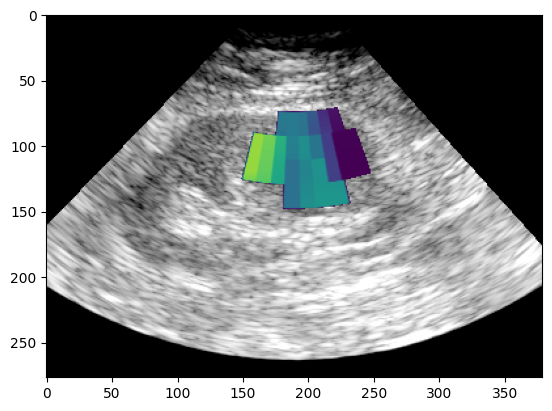

In [27]:
axFrame = 150
plt.imshow(utcData3d.utcAnalysis.ultrasoundImage.scBmode[:,:,axFrame], cmap='gray', aspect='auto')
plt.imshow(utcData3d.scMbfIm[:,:,axFrame])

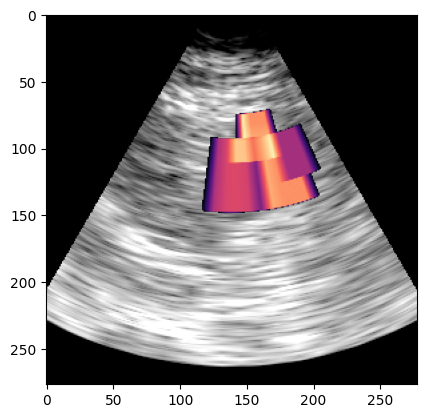

In [30]:
latFrame = 200
plt.imshow(utcData3d.utcAnalysis.ultrasoundImage.scBmode[:,latFrame,:], cmap='gray', aspect='auto')
plt.imshow(utcData3d.scSsIm[:,latFrame,:])

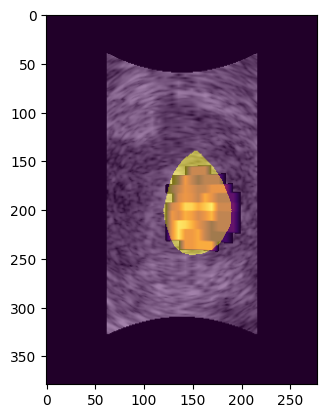

In [32]:
corFrame = 100
plt.imshow(utcData3d.utcAnalysis.ultrasoundImage.scBmode[corFrame,:,:], cmap='gray', aspect='auto')
plt.imshow(utcData3d.scSsIm[corFrame,:,:])
plt.imshow(utcData3d.utcAnalysis.scSegMask[corFrame,:,:], alpha=0.5)

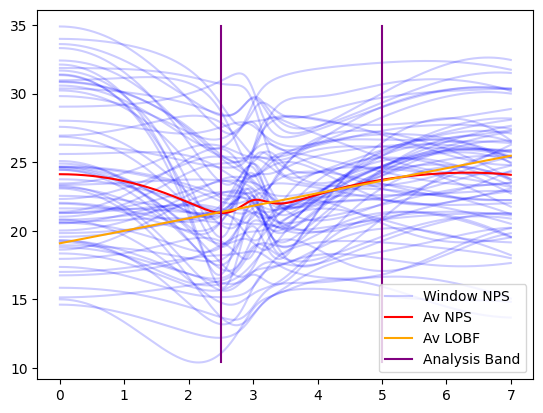

In [33]:
utcData3d.plotPsData()